In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import dump, load
import random
from timeit import default_timer as timer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import streamlit as st
import joblib
import math

%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Model
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, f1_score, make_scorer
from sklearn.metrics import average_precision_score, log_loss, accuracy_score, classification_report, recall_score, precision_score
from bayes_opt import BayesianOptimization
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format

MAX_EVALS = 500
N_FOLDS = 10

global weight_f1
weight_f1 = 1.6

In [2]:
from scipy.misc import derivative

In [3]:
from P7_01_functions import *

In [4]:
def reverse_one_hot_encoding(df):
    status_list = df.to_numpy().argsort()[:,-1]
    temp_list = []
    for idx, x in np.ndenumerate(status_list):
        temp_list.append(df.columns[x])
    
    return temp_list

def anciennete(d) :
    
    if math.isnan(d) :
        return str(np.nan)
    else:
        d = abs(d)
        year = int(np.floor(np.divide(d, 365)))
        month = np.round(np.multiply(np.divide(np.divide(d, 30),12) - year, 12),2)
        day = int(np.multiply(month - np.floor(month), 30))
        month = int(np.floor(month))
        anciennete = str(year) + "a  " + str(month) + "m  " + str(day) + "j"

        return anciennete

def import_data_binary(source = "applications_traintest_feather"):
    raw_data = pd.read_feather(source)
    column = raw_data.columns.str.replace('/', '_')
    column = column.str.replace('-', '_')
    column = column.str.replace(',', '_')
    raw_data.columns = column
    raw_data.set_index('SK_ID_CURR',inplace = True)
    raw_data = reduce_mem_usage(raw_data)
    return raw_data

In [5]:
raw_data = import_data_binary()

Memory usage of dataframe is 103.62 MB
Memory usage after optimization is: 181.08 MB
Decreased by -74.8%


In [6]:
raw_data.shape

(356249, 139)

In [7]:
raw_data.TARGET.value_counts().divide(raw_data.TARGET.value_counts().sum())

0.00   0.92
1.00   0.08
Name: TARGET, dtype: float64

In [8]:
raw_data.isna().sum()

TARGET                                                48744
NAME_CONTRACT_TYPE                                        0
CODE_GENDER                                               0
FLAG_OWN_CAR                                              0
FLAG_OWN_REALTY                                           0
CNT_CHILDREN                                              0
AMT_INCOME_TOTAL                                          0
AMT_CREDIT                                                0
AMT_ANNUITY                                              36
AMT_GOODS_PRICE                                         276
REGION_POPULATION_RELATIVE                                0
DAYS_BIRTH                                                0
DAYS_EMPLOYED                                         64648
DAYS_REGISTRATION                                         0
DAYS_ID_PUBLISH                                           0
OWN_CAR_AGE                                          235237
CNT_FAM_MEMBERS                         

In [9]:
df_test = raw_data.drop(raw_data.dropna(subset=['TARGET']).index)
df_train = raw_data.dropna(subset=['TARGET'])
del raw_data

In [10]:
df_train.isna().sum()

TARGET                                                    0
NAME_CONTRACT_TYPE                                        0
CODE_GENDER                                               0
FLAG_OWN_CAR                                              0
FLAG_OWN_REALTY                                           0
CNT_CHILDREN                                              0
AMT_INCOME_TOTAL                                          0
AMT_CREDIT                                                0
AMT_ANNUITY                                              12
AMT_GOODS_PRICE                                         276
REGION_POPULATION_RELATIVE                                0
DAYS_BIRTH                                                0
DAYS_EMPLOYED                                         55374
DAYS_REGISTRATION                                         0
DAYS_ID_PUBLISH                                           0
OWN_CAR_AGE                                          202925
CNT_FAM_MEMBERS                         

In [11]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.label
  def fl(x,t):
      p = 1/(1+np.exp(-x))
      return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
  partial_fl = lambda x: fl(x, y_true)
  grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
  hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
  return grad, hess


def focal_loss_lgb_f1_score(preds, lgbDataset):
  preds = sigmoid(preds)
  binary_preds = [int(p>0.5) for p in preds]
  y_true = lgbDataset.get_label()
  return 'f1', f1_score(y_true, binary_preds), True

In [12]:
def _positive_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _negative_sigmoid(x):
    exp = np.exp(x)
    return exp / (exp + 1)

def sigmoid(x):
    positive = x >= 0
    negative = ~positive
    result = np.empty_like(x)
    result[positive] = _positive_sigmoid(x[positive])
    result[negative] = _negative_sigmoid(x[negative])
    return result


def _positive_softplus(x):
    return x + np.log1p(np.exp(-x))

def _negative_softplus(x):
    return np.log1p(np.exp(x))

def softplus(x):
    positive = x >= 0
    negative = ~positive
    result = np.empty_like(x)
    result[positive] = _positive_softplus(x[positive])
    result[negative] = _negative_softplus(x[negative])
    return result


def bce_loss(z, data):
    t = data.get_label()
    y = sigmoid(z)
    grad = y - t
    hess = y * (1 - y)
    return grad, hess

def bce_eval(z, data):
    t = data.get_label()
    loss = t * softplus(-z) + (1 - t) * softplus(z)
    return 'bce', loss.mean(), False

In [13]:
df_train.shape

(307505, 139)

In [14]:
mask_categ = ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Rare',
 'NAME_TYPE_SUITE_Spouse_ partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Rare',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary _ secondary special',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Single _ not married',
 'NAME_FAMILY_STATUS_Unknown',
 'NAME_FAMILY_STATUS_Widow',
 'OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE_Core staff',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_HR staff',
 'OCCUPATION_TYPE_High skill tech staff',
 'OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_Low_skill Laborers',
 'OCCUPATION_TYPE_Managers',
 'OCCUPATION_TYPE_Medicine staff',
 'OCCUPATION_TYPE_Realty agents',
 'OCCUPATION_TYPE_Sales staff',
 'OCCUPATION_TYPE_Secretaries',
 'ORGANIZATION_TYPE_Agriculture',
 'ORGANIZATION_TYPE_Business Entity',
 'ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Education',
 'ORGANIZATION_TYPE_Finance',
 'ORGANIZATION_TYPE_Government',
 'ORGANIZATION_TYPE_HotelRestaurant',
 'ORGANIZATION_TYPE_House',
 'ORGANIZATION_TYPE_Industry',
 'ORGANIZATION_TYPE_Other',
 'ORGANIZATION_TYPE_Public',
 'ORGANIZATION_TYPE_Security',
 'ORGANIZATION_TYPE_Self_employed',
 'ORGANIZATION_TYPE_Services',
 'ORGANIZATION_TYPE_Trade',
 'ORGANIZATION_TYPE_Transport',
 'ORGANIZATION_TYPE_XNA']

In [15]:
mask_categ = df_train.drop(mask_categ, axis = 1).columns

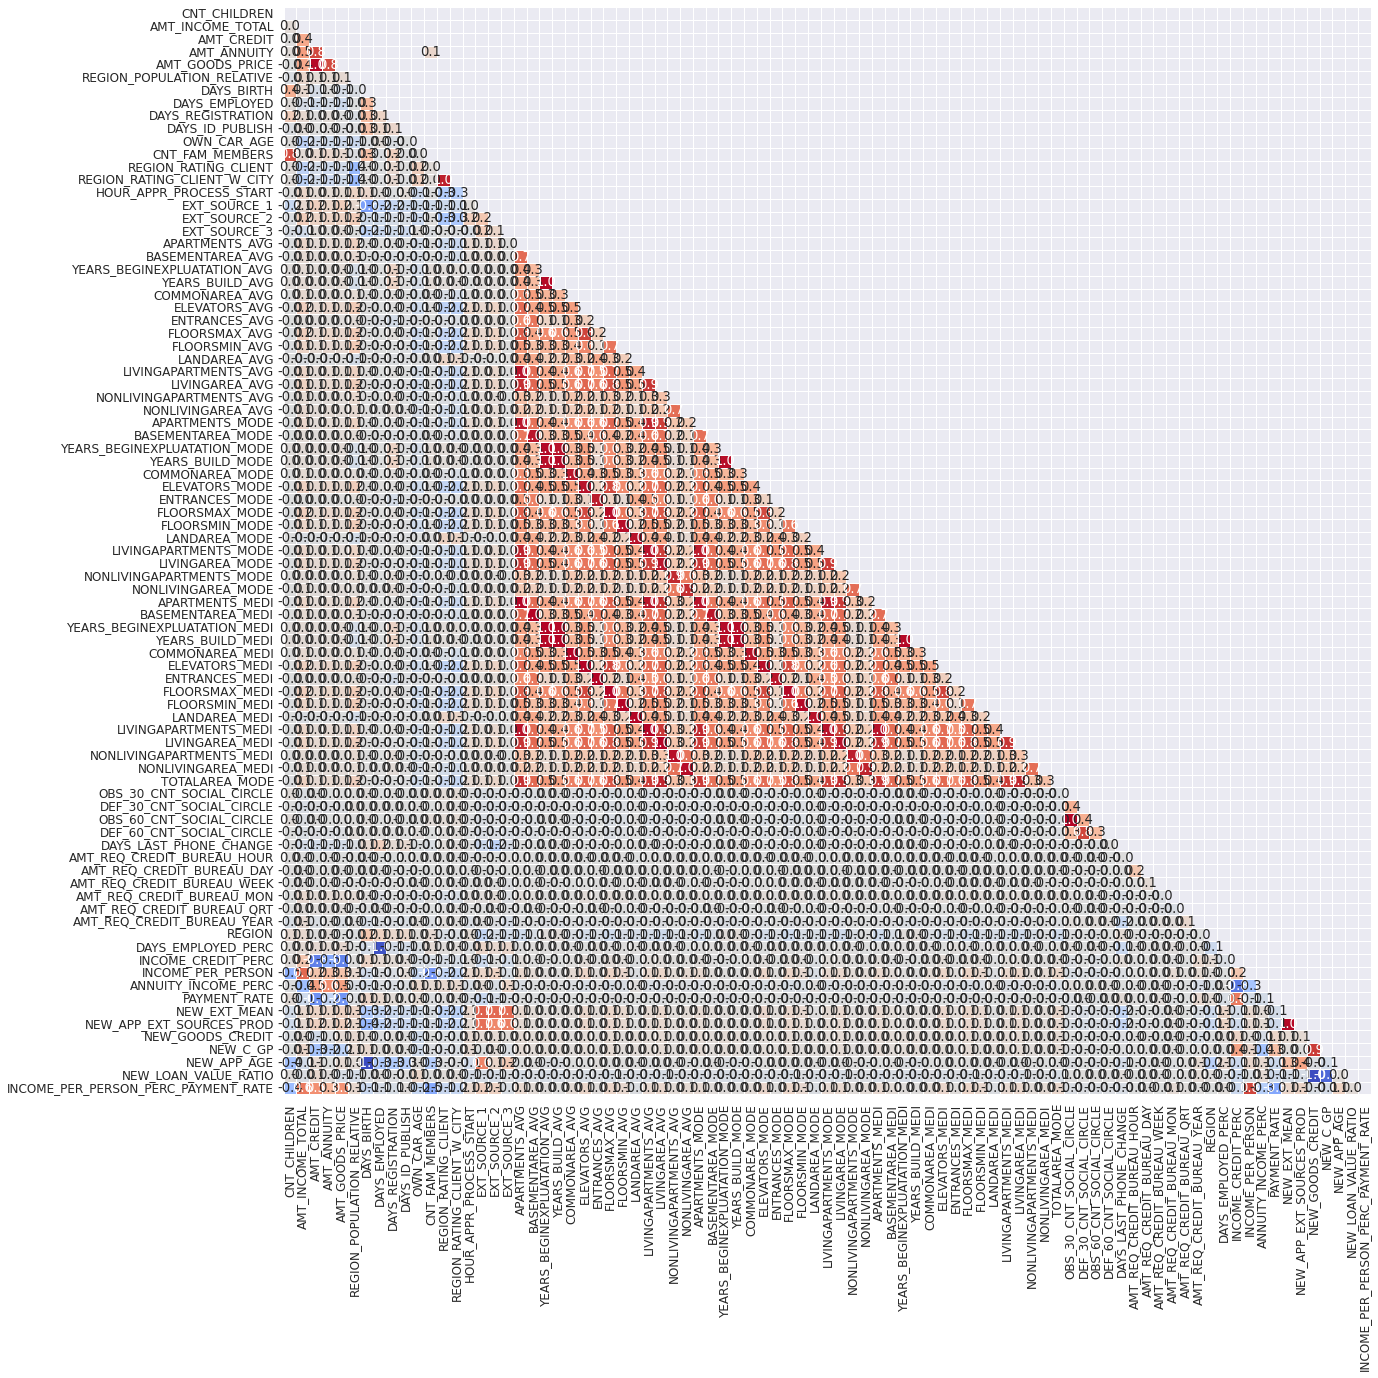

In [16]:
# Correlation
corr_plot(df_train[mask_categ], remove=['TARGET'], corr_coef = "spearman")

In [17]:
high_correlation(df_train[mask_categ], remove=['TARGET'], corr_coef = "spearman", corr_value = 0.90)

AMT_CREDIT
-------------------------------
AMT_GOODS_PRICE   0.98
Name: AMT_CREDIT, dtype: float64


AMT_GOODS_PRICE
-------------------------------
AMT_CREDIT   0.98
Name: AMT_GOODS_PRICE, dtype: float64


DAYS_BIRTH
-------------------------------
NEW_APP_AGE   -1.00
Name: DAYS_BIRTH, dtype: float64


DAYS_EMPLOYED
-------------------------------
DAYS_EMPLOYED_PERC   -0.97
Name: DAYS_EMPLOYED, dtype: float64


REGION_RATING_CLIENT
-------------------------------
REGION_RATING_CLIENT_W_CITY   0.95
Name: REGION_RATING_CLIENT, dtype: float64


REGION_RATING_CLIENT_W_CITY
-------------------------------
REGION_RATING_CLIENT   0.95
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64


APARTMENTS_AVG
-------------------------------
APARTMENTS_MEDI         1.00
LIVINGAPARTMENTS_AVG    0.97
LIVINGAPARTMENTS_MEDI   0.97
APARTMENTS_MODE         0.96
LIVINGAPARTMENTS_MODE   0.94
LIVINGAREA_AVG          0.91
LIVINGAREA_MEDI         0.90
Name: APARTMENTS_AVG, dtype: float64


BASEMENTAREA_AVG
-----

In [18]:
col_corr = ['AMT_GOODS_PRICE', 'NEW_APP_AGE', 'DAYS_EMPLOYED_PERC', 'REGION_RATING_CLIENT_W_CITY',
            'APARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'APARTMENTS_MODE',
            'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_AVG',
            'YEARS_BUILD_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MEDI',
            'COMMONAREA_MODE', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_MODE',
            'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI',
            'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
            'NEW_APP_EXT_SOURCES_PROD', 'NEW_LOAN_VALUE_RATIO', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [19]:
mask_categ

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
 

In [20]:
mask_categ = list(mask_categ)

for i in col_corr :
    if i in mask_categ:
        mask_categ.remove(i)
    

In [21]:
df_train = df_train.drop(col_corr, axis = 1)

In [22]:
df_train.describe()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,NAME_TYPE_SUITE_Spouse_ partner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary _ secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single _ not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_C_GP,INCOME_PER_PERSON_PERC_PAYMENT_RATE
count,"307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,493.00","307,505.00","307,505.00","252,131.00","307,505.00","307,505.00","104,580.00","307,505.00","307,505.00","307,505.00","151,446.00","127,564.00","157,500.00","92,644.00","143,616.00","152,679.00","154,487.00","98,866.00","124,919.00","153,157.00","93,994.00","137,826.00","97,309.00","153,157.00","93,994.00","137,826.00","153,157.00","137,826.00","159,076.00","306,484.00","306,484.00","306,484.00","307,504.00","265,987.00","265,987.00","265,987.00","265,987.00","265,987.00","265,987.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,505.00","307,493.00","307,493.00","307,333.00","307,229.00","307,229.00","307,493.00"
mean,0.08,0.10,0.66,0.34,0.31,0.42,"168,737.84","598,833.19","27,111.02",0.02,"-16,037.05","-2,384.15","-4,986.06","-2,994.20",12.06,2.15,2.05,12.06,0.12,0.09,0.98,0.04,0.08,0.15,

In [23]:
list(df_train.columns)

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'LIVINGAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AM

In [24]:
solvable = df_train[df_train['TARGET']==0]
non_sovable = df_train[df_train['TARGET']==1]
solvable = solvable.sample(n=len(non_sovable), random_state=101)
df_train_reduce = pd.concat([solvable,non_sovable],axis=0)


x = df_train_reduce.drop('TARGET', axis=1)
y = df_train_reduce.TARGET

#x.fillna(x.mean(), inplace=True)

del df_train_reduce
df_train_stand = df_train.drop('TARGET',axis=1).copy()

#oversample = SMOTE(sampling_strategy=0.1)
#x, y = oversample.fit_resample(x, y)
#undersample = RandomUnderSampler(sampling_strategy=0.5)
#x, y = undersample.fit_resample(x, y)




x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [25]:
scaler_x = StandardScaler()


x_train[mask_categ] = scaler_x.fit_transform(x_train[mask_categ])
x_test[mask_categ] = scaler_x.transform(x_test[mask_categ])
df_train_stand[mask_categ] = scaler_x.transform(df_train_stand[mask_categ])

In [26]:
df_train.TARGET.value_counts()

0.00    282680
1.00     24825
Name: TARGET, dtype: int64

In [27]:
x_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,NAME_TYPE_SUITE_Spouse_ partner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary _ secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single _ not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_C_GP,INCOME_PER_PERSON_PERC_PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
214959,0,1,0,0,0.77,-0.12,1.42,1.52,-0.93,1.25,0.93,0.63,0.63,NaN,0.90,1.77,-1.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.35,-0.62,-0.30,-1.50,NaN,NaN,NaN,NaN,NaN,NaN,-0.59,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.27,-0.28,3.65,-0.54,-0.63,-0.84,-3.66,-0.26
220922,0,1,0,0,-0.59,-0.07,1.03,0.59,-0.38,0.90,-0.27,1.08,1.55,NaN,-0.18,-0.19,1.24,0.57,0.09,0.04,-0.58,-0.56,-1.12,-0.36,-1.17,-0.31,-0.31,0.36,0.05,0.50,-0.27,0.38,0.10,-0.30,0.06,-0.35,-0.35,0.23,-0.30,-0.01,-0.08,-0.07,-0.16,-0.30,1.20,0.03,-0.59,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.23,-0.14,1.09,-0.84,0.20,1.10,0.85,-0.06
129231,0,1,1,1,0.77,-0.09,-0.15,0.72,-0.84,0.94,-0.47,-0.13,0.45,4.21,-0.18,-0.19,2.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.74,-0.19,2.25,-0.46,-0.08,-0.07,-0.16,0.90,-0.42,-0.50,1.18,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0

In [28]:
train = lgb.Dataset(data=x_train, 
         label=y_train)

In [29]:
def evaluate_macroF1_lgb(predictions, truth):
    truth = truth.get_label()
    
    mask = truth ==1
    pred_labels = np.where(predictions < 0.5, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    
    recall = TP / (TP + FN)

    precision = TP / (TP + FP)

    F1 = (weight_f1+1)/(weight_f1/recall + 1/precision)
    
    if np.isnan(F1) :
        F1 = 0
    
    print(F1)
    return ('F1_weighted', F1, True) 

def evaluate_macroF1_lgb_cv(truth, predictions):

    mask = truth ==1
    pred_labels = np.where(predictions < 0.5, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = (weight_f1+1)/(weight_f1/recall + 1/specificity)
    
    return (F1)

def evaluate_roc_auc_lgb_cv(truth, predictions):

    mask = truth ==1
    pred_labels = np.where(predictions < 0.5, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = ((weight_f1**2)+1)*((specificity*recall)/(specificity*(weight_f1**2)+recall))
    
    return (F1)

def evaluate_roc_aucdirect_lgb(truth, predictions):

    mask = truth ==1
    pred_labels = predictions
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = ((weight_f1**2)+1)*((specificity*recall)/(specificity*(weight_f1**2)+recall))
    
    return (F1)

def evaluate_macroF1bis_lgb_cv(truth, predictions):

    mask = truth ==1
    pred_labels = np.where(predictions < 0.5, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = ((weight_f1**2)+1)*((precision*recall)/(precision*(weight_f1**2)+recall))
    
    return (F1)

def evaluate_macroF1direct_lgb(truth, predictions):

    mask = truth ==1
    pred_labels = predictions
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = ((weight_f1**2)+1)*((precision*recall)/(precision*(weight_f1**2)+recall))
    
    return (F1)

## Optimisation Bayesian des hyper-paramètres

In [204]:
def hyperopt_train_test(params):
    X_ = x_train[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
            del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
            del params['scale']
    clf = LGBMClassifier(**params)
    return cross_val_score(clf, x_train, y_train, scoring=make_scorer(evaluate_macroF1_lgb_cv, greater_is_better=True)).mean()
space4rf = {
            'class_weight': hp.choice('class_weight', ['balanced', None]),
            'colsample_bytree': hp.choice('colsample_bytree', np.around(np.linspace(0, 1, 20),3)),
            'learning_rate': hp.choice('learning_rate', np.around(np.linspace(0, 1, 30), 3)),
            'max_depth': hp.choice('max_depth', np.arange(1, 1000, 50)),
            'min_child_samples': hp.choice('min_child_samples', np.arange(1, 1000, 30)),
            'num_leaves': hp.choice('num_leaves', np.arange(1, 1000, 30)),
            'reg_alpha': hp.choice('reg_alpha', np.around(np.linspace(0, 1, 20),3)),
            'reg_lambda': hp.choice('reg_lambda', np.around(np.linspace(0, 1, 20), 3)),
            'subsample': hp.choice('subsample', np.around(np.linspace(0, 1, 30),3))
}
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
    print('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)
print('best: ' + str(best))

0.6686692700510664                                     
0.6677680985280865                                     
0.6842895764493842                                     
0.6828828828828829                                     
0.6768768768768769                                     
new best:                                              
0.6811195975314034                                     
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.897, 'max_depth': 1, 'min_child_samples': 31, 'num_leaves': 721, 'reg_alpha': 0.368, 'reg_lambda': 0.947, 'subsample': 0.069}
0.6422349053769901                                                                
0.6377290477620907                                                                
0.6578552117753079                                                                
0.654054054054054                                                                 
0.6537537537537538                                                         

0.6698708320817062                                                                 
0.6696696696696697                                                                 
0.6702702702702703                                                                 
new best:                                                                          
0.6871787995667635                                                                 
{'class_weight': None, 'colsample_bytree': 1.0, 'learning_rate': 0.345, 'max_depth': 851, 'min_child_samples': 31, 'num_leaves': 271, 'reg_alpha': 0.842, 'reg_lambda': 0.474, 'subsample': 0.517}
0.6776809852808652                                                                 
0.6746770802042655                                                                 
0.693301291679183                                                                  
0.6942942942942943                                                                 
0.684084084084084                                

new best:                                                                          
0.6873808629109952                                                                 
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.759, 'max_depth': 401, 'min_child_samples': 391, 'num_leaves': 1, 'reg_alpha': 0.895, 'reg_lambda': 0.158, 'subsample': 0.276}
0.6338239711625112                                                                 
0.6341243616701713                                                                 
0.6551516972063682                                                                 
0.651951951951952                                                                  
0.6483483483483483                                                                 
new best:                                                                          
0.6873808629109952                                                                 
{'class_weight': None, 'colsample_bytree': 0.895, 

new best:                                                                          
0.6873808629109952                                                                 
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 391, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 1.0, 'subsample': 0.552}
new best:                                                                          
0.6873808629109952                                                                 
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.897, 'max_depth': 1, 'min_child_samples': 571, 'num_leaves': 541, 'reg_alpha': 0.474, 'reg_lambda': 1.0, 'subsample': 0.276}
new best:                                                                          
0.6873808629109952                                                                 
{'class_weight': None, 'colsample_bytree': 0.421, 'learning_rate': 0.0, 'max_depth': 1, 'min_child_samples': 871, 

new best:                                                                          
0.6873808629109952                                                                 
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 1, 'min_child_samples': 121, 'num_leaves': 301, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.414}
new best:                                                                          
0.6873808629109952                                                                 
{'class_weight': None, 'colsample_bytree': 0.053, 'learning_rate': 0.0, 'max_depth': 1, 'min_child_samples': 391, 'num_leaves': 661, 'reg_alpha': 0.474, 'reg_lambda': 0.579, 'subsample': 0.276}
new best:                                                                          
0.6873808629109952                                                                 
{'class_weight': None, 'colsample_bytree': 0.421, 'learning_rate': 0.0, 'max_depth': 1, 'min_child_samples': 121, 

0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.828, 'max_depth': 601, 'min_child_samples': 541, 'num_leaves': 541, 'reg_alpha': 0.421, 'reg_lambda': 0.789, 'subsample': 0.0}
new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.828, 'max_depth': 601, 'min_child_samples': 721, 'num_leaves': 721, 'reg_alpha': 0.526, 'reg_lambda': 0.842, 'subsample': 0.379}
0.6701712225893661                                                                  
0.671973565635326                                                                   
0.6734755181736257                                                                  
0.6852852852852853                                                                  
0.6771771771771

{'class_weight': None, 'colsample_bytree': 0.316, 'learning_rate': 0.241, 'max_depth': 551, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 0.158, 'reg_lambda': 0.105, 'subsample': 0.0}
new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 701, 'min_child_samples': 571, 'num_leaves': 721, 'reg_alpha': 0.947, 'reg_lambda': 0.105, 'subsample': 0.0}
new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.684, 'learning_rate': 0.0, 'max_depth': 51, 'min_child_samples': 301, 'num_leaves': 721, 'reg_alpha': 0.526, 'reg_lambda': 0.105, 'subsample': 0.828}
new best:                                                                    

0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.474, 'learning_rate': 0.483, 'max_depth': 551, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 0.895, 'reg_lambda': 0.211, 'subsample': 0.0}
new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.474, 'learning_rate': 0.0, 'max_depth': 551, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 0.579, 'reg_lambda': 0.211, 'subsample': 0.0}
new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.211, 'learning_rate': 0.0, 'max_depth': 551, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 0.579, 'reg_lambda': 0.842, 'subsample': 0.

new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 331, 'num_leaves': 61, 'reg_alpha': 0.579, 'reg_lambda': 0.211, 'subsample': 0.483}
new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.474, 'learning_rate': 0.69, 'max_depth': 551, 'min_child_samples': 301, 'num_leaves': 1, 'reg_alpha': 0.579, 'reg_lambda': 0.842, 'subsample': 0.0}
new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 451, 'min_child_sampl

new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.69, 'max_depth': 551, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 0.579, 'reg_lambda': 0.842, 'subsample': 0.0}
new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 551, 'min_child_samples': 301, 'num_leaves': 1, 'reg_alpha': 0.947, 'reg_lambda': 0.211, 'subsample': 0.483}
new best:                                                                           
0.6873808629109952                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.448, 'max_depth': 301, 'min_child_sample

0 colsample_bytree
1 learning_rate
2 max_depth
3 min_child_samples
4 num_leaves
5 reg_alpha
6 reg_lambda
7 subsample


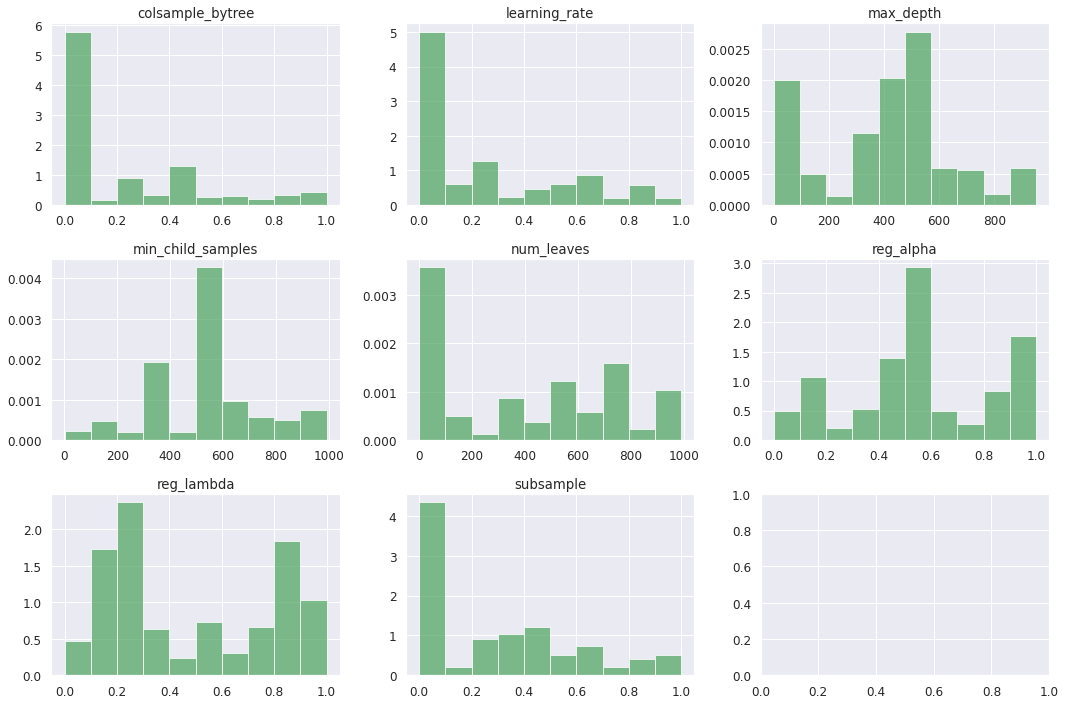

In [291]:

x_line = [np.around(np.linspace(0, 1, 20),3), np.around(np.linspace(0, 1, 30), 3), np.arange(1, 1000, 50),
 np.arange(1, 1000, 30), np.arange(1, 1000, 30), np.around(np.linspace(0, 1, 20),3),
 np.around(np.linspace(0, 1, 20), 3), np.around(np.linspace(0, 1, 30),3)]


parameters = ['colsample_bytree', 'learning_rate', 'max_depth', 'min_child_samples', 'num_leaves', 'reg_alpha',
             'reg_lambda', 'subsample']
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print(i, val)
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    k=0
    xss = []
    for j in xs:
        xss.append(x_line[i][j])
        k +=1
    #axes[int(i/3),i%3].catplot(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[int(i/3),i%3].hist(xss, 50, density=1, facecolor='g', alpha=0.75)
    axes[int(i/3),i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])
plt.tight_layout()

In [30]:
params = {'class_weight': [None],
          'colsample_bytree': np.linspace(0, 0.5, 5),
          'learning_rate': np.linspace(0, 0.3, 10),
          'max_depth': np.arange(400, 600, 10),
          'min_child_samples': np.arange(500, 625, 10),
          'num_leaves': np.arange(500, 950, 10),
          'reg_alpha': np.linspace(0.4, 1, 10),
          'reg_lambda': np.linspace(0, 0.3, 10),
          'subsample': np.linspace(0.2, 0.65, 10)}

In [133]:
test_weight = [1.4, 1.5, 1.6, 1.8, 1.9, 2]
threshold = np.linspace(0,1, 101)

score_l = np.ndarray((101, 7))
m = 1

for i in test_weight:
    
    weight_f1 = i
    lgbmclassifier = LGBMClassifier(metric="custom")
    lgbm_random = RandomizedSearchCV(estimator = lgbmclassifier, param_distributions = params, scoring=make_scorer(evaluate_roc_auc_lgb_cv, greater_is_better=True), n_iter = 200, cv = 5, verbose=150, random_state=42, n_jobs = -1)# Fit the random search model 
    lgbm_random.fit(x_train, y_train)
    proba_train = lgbm_random.predict_proba(x_train)
    pred_test = lgbm_random.predict_proba(x_test)
    
    best_score = [0, 0] 
    k = 0
    
    for j in threshold: 
        pred_train = np.where(proba_train[:,1]>j,1,0)
        score_l[k,0] = j
        score_l[k,m] = evaluate_roc_aucdirect_lgb(y_train, pred_train)
        if score_l[k,m] > best_score[1]:
            best_score[0] = score_l[k,0]
            best_score[1] = score_l[k,m]
        k += 1
    
    pred_test = lgbm_random.predict_proba(x_test)
    pred_train = np.where(proba_train[:,1]>best_score[0],1,0)
    pred_test = np.where(pred_test[:,1]>best_score[0],1,0)
    
    TN, FP, FN, TP = confusion_matrix(y_train, pred_train).ravel()
    specificity_train = TN / (TN + FP)
    TN, FP, FN, TP = confusion_matrix(y_test, pred_test).ravel()
    specificity_test = TN / (TN + FP)
    
    print("\n\nTEST poids :", i, "Threshold : ", best_score[0], "\n",
         "-------------------\n",
          "ROC_AUC_pondéré : " + str(best_score[1]),
         "\n-------------------\n",
         "Recall score train : " + str(recall_score(y_train, pred_train)), "\n",
         "Recall score test : " + str(recall_score(y_test, pred_test)), "\n",
         "-------------------\n",
         "Specificity score train : " + str(specificity_train) + "\n",
         "Specificity score test : " + str(specificity_test) + "\n")
    
    m += 1

score_l = pd.DataFrame(score_l, columns = ['Threshold', 'weight_100', 'weight_125', 'weight_150', 'weight_200', 'weight_500', 'weight_1000'])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


TEST poids : 1.4 Threshold :  0.44 
 -------------------
 ROC_AUC_pondéré : 0.7589446143756221 
-------------------
 Recall score train : 0.8203279870246891 
 Recall score test : 0.768647591098068 
 -------------------
 Specificity score train : 0.6618726681911181
 Specificity score test : 0.6043621298891191

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


TEST poids : 1.5 Threshold :  0.43 
 -------------------
 ROC_AUC_pondéré : 0.7647147833947888 
-------------------
 Recall score train : 0.8331831561242266 
 Recall score test : 0.7801418439716312 
 -------------------
 Specificity score train : 0.6453845228065953
 Specificity score test : 0.5871816741805775

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


TEST poids : 1.6 Threshold :  0.43 
 -------------------
 ROC_AUC_pondéré : 0.7702264079367577 
-------------------
 Recall score train : 0.8331831561242266 
 Recall score test : 

In [32]:
weight_f1 = 1.4
threshold = 0.44
lgbmclassifier = LGBMClassifier(metric="custom")
lgbm_random = RandomizedSearchCV(estimator = lgbmclassifier, param_distributions = params, scoring=make_scorer(evaluate_roc_auc_lgb_cv, greater_is_better=True), n_iter = 200, cv = 5, verbose=150, random_state=42, n_jobs = -1)# Fit the random search model 
lgbm_random.fit(x_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(metric='custom'), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'class_weight': [None],
                                        'colsample_bytree': array([0.   , 0.125, 0.25 , 0.375, 0.5  ]),
                                        'learning_rate': array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ]),
                                        'max_depth': array([400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500...
       890, 900, 910, 920, 930, 940]),
                                        'reg_alpha': array([0.4       , 0.46666667, 0.53333333, 0.6       , 0.66666667,
       0.73333333, 0.8       , 0.86666667, 0.93333333, 1.        ]),
                                        'reg_lambda': array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3     

In [33]:
pred_train = lgbm_random.predict_proba(x_train)
pred_test = lgbm_random.predict_proba(x_test)
pred_train = np.where(pred_train[:,1]>threshold,1,0)
pred_test = np.where(pred_test[:,1]>threshold,1,0)

In [34]:
filename = 'Streamlit/LightGBMModel.json' 
outfile = open(filename,'wb') 
joblib.dump(lgbm_random.best_estimator_, outfile) 
outfile.close()

In [35]:
lgbm_random.best_params_

{'subsample': 0.6000000000000001,
 'reg_lambda': 0.3,
 'reg_alpha': 0.8,
 'num_leaves': 890,
 'min_child_samples': 570,
 'max_depth': 400,
 'learning_rate': 0.13333333333333333,
 'colsample_bytree': 0.25,
 'class_weight': None}

In [36]:
lgbm_random.best_score_

0.6865204672885432

In [37]:
print("Recall score train : " + str(recall_score(y_train, pred_train)))
print("Recall score test : " + str(recall_score(y_test, pred_test)))

Recall score train : 0.8203279870246891
Recall score test : 0.768647591098068


In [38]:
print("Accuracy score train : " + str(accuracy_score(y_train, pred_train)))
print("Accuracy score test : " + str(accuracy_score(y_test, pred_test)))

Accuracy score train : 0.741169397264392
Accuracy score test : 0.6863594751296918


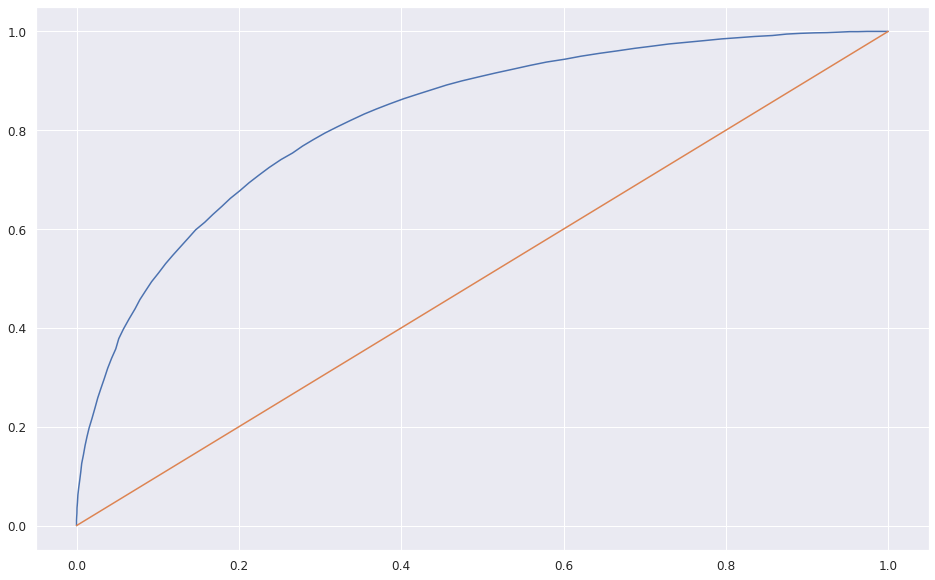

In [39]:
auc_roc = np.ndarray((101, 3), 'float16')
j = 0

for i in np.linspace(0, 1, 101):
    
    predictions = lgbm_random.predict_proba(x_train)[:,1]
    truth = y_train
    mask = truth ==1
    pred_labels = np.where(predictions < i, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    FPR = 1 - specificity
    auc_roc[j, 0] = recall
    auc_roc[j, 1] = FPR
    auc_roc[j, 2] = i
    j +=1

plt.figure(figsize=(16,10))
plt.plot(auc_roc[:, 1], auc_roc[:, 0])
plt.plot([0,1], [0,1])
plt.grid(True)
plt.show()

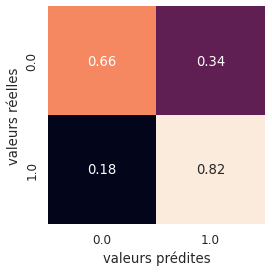

In [40]:
conf = confusion_matrix(y_train, pred_train, normalize='true')


sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(y_train.unique())
            , yticklabels=list(y_train.unique()))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.show()

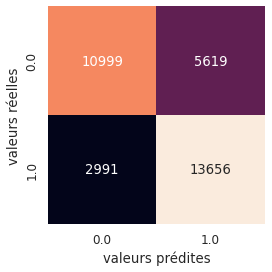

In [41]:
conf = confusion_matrix(y_train, pred_train)


sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(y_train.unique())
            , yticklabels=list(y_train.unique()), fmt = '.5g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.show()

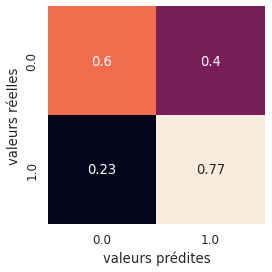

In [42]:
conf = confusion_matrix(y_test, pred_test, normalize='true')


sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(y_train.unique())
            , yticklabels=list(y_train.unique()))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.show()

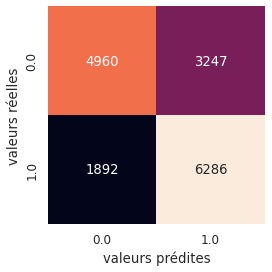

In [43]:
conf = confusion_matrix(y_test, pred_test)


sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(y_train.unique())
            , yticklabels=list(y_train.unique()), fmt = '.5g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.show()

100%|===================| 33107/33265 [03:10<00:00]        

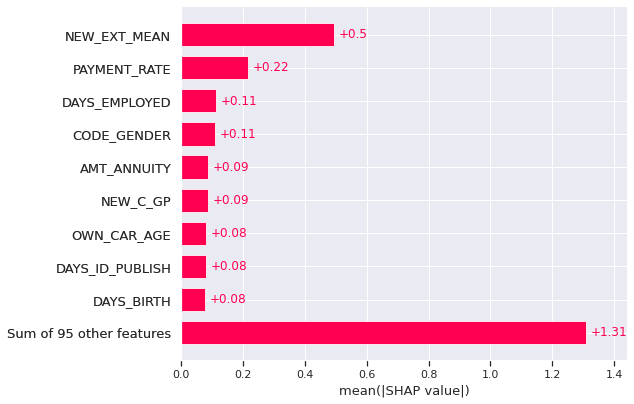

In [44]:
explainer = shap.TreeExplainer(lgbm_random.best_estimator_, x_train)
shap_values = explainer(x_train)

shap.plots.bar(shap_values)

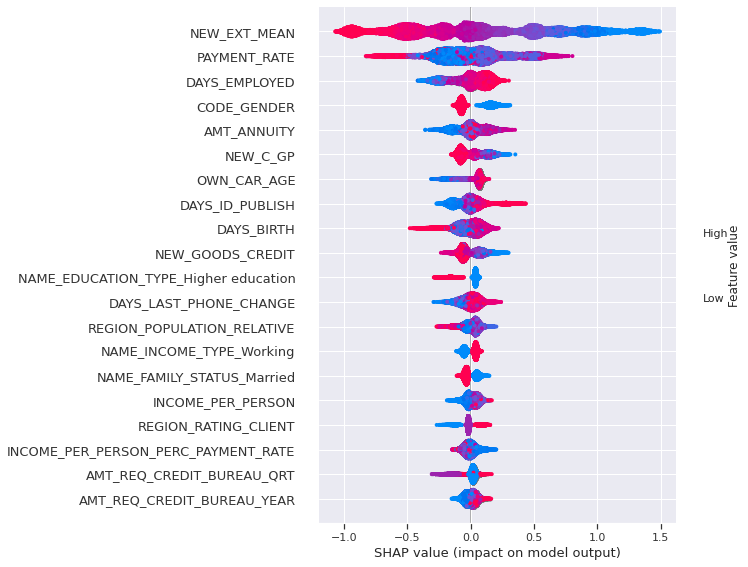

In [45]:
shap.summary_plot(shap_values, feature_names=x_train.columns)

## Nearest Neighbors

In [65]:
raw_data = import_data_binary()
raw_data = raw_data.drop('TARGET', axis=1)
raw_scaled = raw_data.drop(col_corr, axis = 1).copy()
raw_scaled[mask_categ] = scaler_x.transform(raw_scaled[mask_categ])

Memory usage of dataframe is 103.62 MB
Memory usage after optimization is: 181.08 MB
Decreased by -74.8%


In [66]:
raw_scaled = raw_scaled.sample(n=100, random_state=101)
sample_index = raw_scaled.index
raw_data = raw_data.loc[sample_index,:]

In [67]:
raw_scaled.to_csv("Streamlit/DATA_SCALED.csv")

In [68]:
raw_data.columns.tolist()

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLI

In [70]:
raw_data.columns = ['Type_credit',
 'Genre',
 'Voiture',
 'Proprietaire',
 'Enfants',
 'Revenus',
 'Montant_credit',
 'Cout_annuel_credit',
 'Valeur_bien_finance',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'Anciennete_emploi_actuel',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'Taille_foyer',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'REGION',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Rare',
 'NAME_TYPE_SUITE_Spouse_ partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Rare',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'Higher education',
 'Incomplete higher',
 'Lower secondary',
 'Secondary _ secondary special',
 'PACS',
 'Marrie',
 'Separe',
 'Celibataire',
 'Inconnu',
 'veuf_veuve',
 'OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE_Core staff',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_HR staff',
 'OCCUPATION_TYPE_High skill tech staff',
 'OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_Low_skill Laborers',
 'OCCUPATION_TYPE_Managers',
 'OCCUPATION_TYPE_Medicine staff',
 'OCCUPATION_TYPE_Realty agents',
 'OCCUPATION_TYPE_Sales staff',
 'OCCUPATION_TYPE_Secretaries',
 'ORGANIZATION_TYPE_Agriculture',
 'ORGANIZATION_TYPE_Business Entity',
 'ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Education',
 'ORGANIZATION_TYPE_Finance',
 'ORGANIZATION_TYPE_Government',
 'ORGANIZATION_TYPE_HotelRestaurant',
 'ORGANIZATION_TYPE_House',
 'ORGANIZATION_TYPE_Industry',
 'ORGANIZATION_TYPE_Other',
 'ORGANIZATION_TYPE_Public',
 'ORGANIZATION_TYPE_Security',
 'ORGANIZATION_TYPE_Self_employed',
 'ORGANIZATION_TYPE_Services',
 'ORGANIZATION_TYPE_Trade',
 'ORGANIZATION_TYPE_Transport',
 'ORGANIZATION_TYPE_XNA',
 'DAYS_EMPLOYED_PERC',
 'INCOME_CREDIT_PERC',
 'INCOME_PER_PERSON',
 'Annuite/revenus',
 'PAYMENT_RATE',
 'NEW_EXT_MEAN',
 'NEW_APP_EXT_SOURCES_PROD',
 'NEW_GOODS_CREDIT',
 'NEW_C_GP',
 'Age',
 'NEW_LOAN_VALUE_RATIO',
 'INCOME_PER_PERSON_PERC_PAYMENT_RATE']

mask = ['Type_credit',
 'Genre',
 'Voiture',
 'Proprietaire',
 'Enfants',
 'Revenus',
 'Montant_credit',
 'Cout_annuel_credit',
 'Valeur_bien_finance',
 'Anciennete_emploi_actuel',
 'Taille_foyer',
 'Higher education',
 'Incomplete higher',
 'Lower secondary',
 'Secondary _ secondary special',
 'PACS',
 'Marrie',
 'Separe',
 'Celibataire',
 'Inconnu',
 'veuf_veuve',
 'Annuite/revenus',
 'Age']

raw_data = raw_data.loc[:, mask] 
del mask

In [71]:
raw_data.columns

Index(['Type_credit', 'Genre', 'Voiture', 'Proprietaire', 'Enfants', 'Revenus',
       'Montant_credit', 'Cout_annuel_credit', 'Valeur_bien_finance',
       'Anciennete_emploi_actuel', 'Taille_foyer', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Secondary _ secondary special',
       'PACS', 'Marrie', 'Separe', 'Celibataire', 'Inconnu', 'veuf_veuve',
       'Annuite/revenus', 'Age'],
      dtype='object')

In [72]:
raw_data['Education'] = reverse_one_hot_encoding(raw_data.loc[:, ['Higher education',
 'Incomplete higher',
 'Lower secondary',
 'Secondary _ secondary special']])
raw_data = raw_data.drop(['Higher education',
 'Incomplete higher',
 'Lower secondary',
 'Secondary _ secondary special'] ,axis=1)

raw_data['Statut_Marital'] = reverse_one_hot_encoding(raw_data.loc[:, ['PACS',
 'Marrie',
 'Separe',
 'Celibataire',
 'Inconnu',
 'veuf_veuve']])
raw_data = raw_data.drop(['PACS',
 'Marrie',
 'Separe',
 'Celibataire',
 'Inconnu',
 'veuf_veuve'] ,axis=1)

tempo_list = [['revolving', 'cash_credit'],
['homme', 'femme'],
[True, False],
[True, False]]

for i in range(0, 4, 1):
    raw_data[raw_data.columns[i]] = raw_data[raw_data.columns[i]].apply(lambda x: np.where(x, tempo_list[i][0], tempo_list[i][1]))

del tempo_list 


raw_data["Anciennete_emploi_actuel"] = raw_data["Anciennete_emploi_actuel"].apply(lambda x: anciennete(x))

In [73]:
raw_data.to_csv("Streamlit/DATA.csv")